<a href="https://colab.research.google.com/github/2k4sm/colab/blob/main/ola_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ola Cabs Business Case - Ensemble Learning

This notebook covers the solution for predicting driver attrition at Ola using ensemble learning techniques. It includes the following steps:

1. **Problem Definition & Exploratory Data Analysis (EDA)**
2. **Data Preprocessing** (including KNN Imputation, data aggregation, feature engineering, encoding, standardization, and class imbalance treatment)
3. **Model Building** using Ensemble methods (Bagging and Boosting)
4. **Results Evaluation** (Classification Report and ROC AUC curves)
5. **Actionable Insights & Recommendations** along with answers to the provided questionnaire

Follow the cells sequentially for a complete run-through of the solution.

## Order 1: Setup and Import Libraries

In [4]:
# Order 1: Setup and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Inline plotting
%matplotlib inline

print('Libraries imported successfully.')


Libraries imported successfully.


## Order 2: Download and Load Dataset

The dataset is available on Google Drive. We use `gdown` to download the CSV file and then load it into a pandas DataFrame.

In [5]:
# Order 2: Download and Load Dataset
# Install gdown for downloading files from Google Drive (if not already installed)
!pip install -q gdown

# Download the dataset using the provided Google Drive link
!gdown --id 16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl -O ola_driver_data.csv

# Load the dataset
df = pd.read_csv('ola_driver_data.csv')
print('Dataset loaded successfully. Shape:', df.shape)
df.head()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl
To: /content/ola_driver_data.csv
100% 1.13M/1.13M [00:00<00:00, 54.3MB/s]
Dataset loaded successfully. Shape: (19104, 14)


/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


## Order 3: Exploratory Data Analysis (EDA)

In [6]:
# Order 3a: Checking the structure and summary of the dataset
print('Dataset Info:')
df.info()

print('\nStatistical Summary:')
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB

,Unnamed: 0,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,9551.500000,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,19103.000000,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [7]:
# Order 3b: Check for missing values and convert date-like features
print('Missing Values per Column:')
print(df.isnull().sum())

# Converting date-like features to datetime data type
date_columns = ['MMM-YY', 'Dateofjoining', 'LastWorkingDate']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print('Date conversion done.')
df.head()

Missing Values per Column:
Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64
Date conversion done.


<ipython-input-7-e266a88183ad>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-7-e266a88183ad>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-7-e266a88183ad>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


### Univariate Analysis

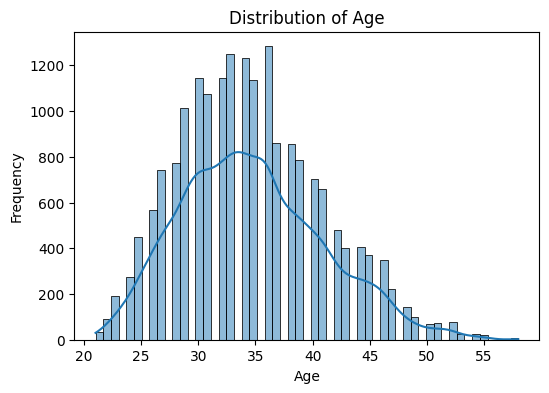

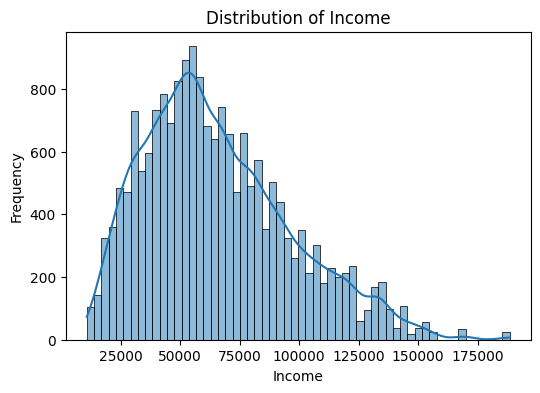

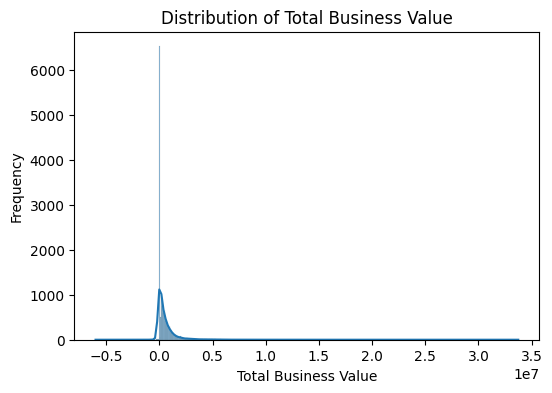

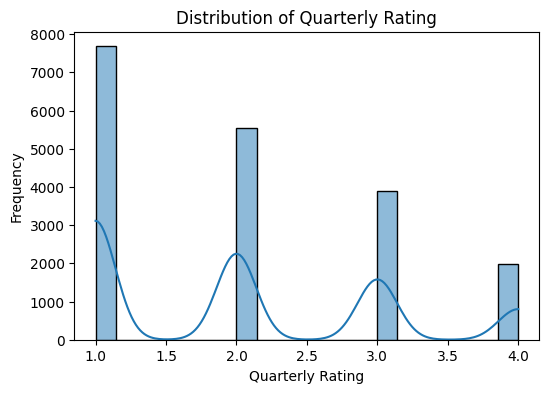

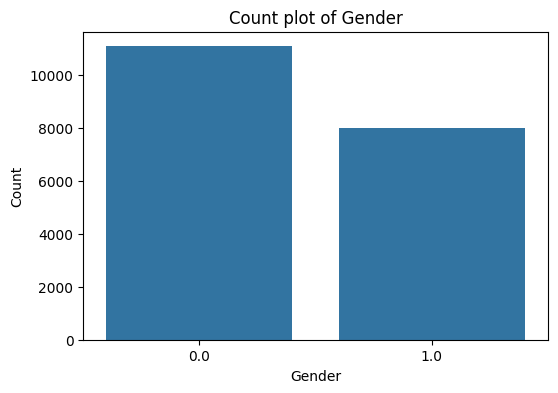

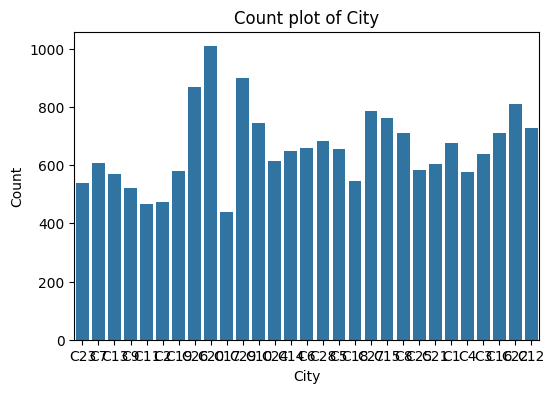

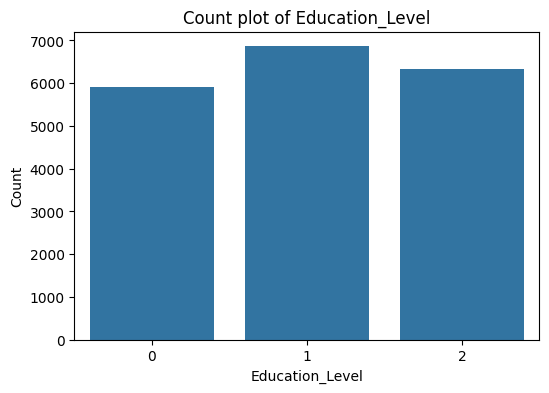

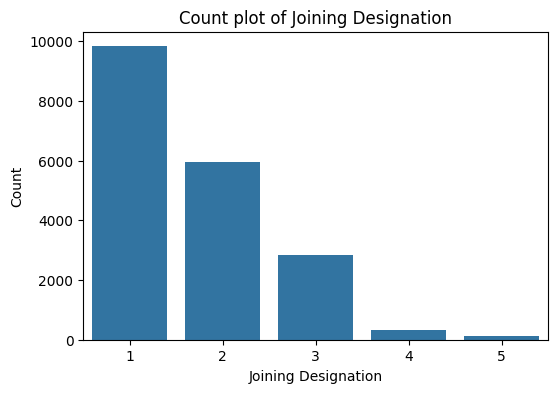

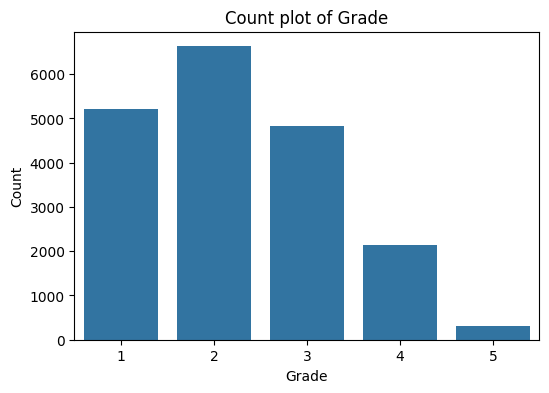

In [8]:
# Order 3c: Univariate Analysis - Distribution plots for continuous variables
continuous_vars = ['Age', 'Income', 'Total Business Value', 'Quarterly Rating']
for col in continuous_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Order 3d: Univariate Analysis - Count plots for categorical variables
categorical_vars = ['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']
for col in categorical_vars:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### Bivariate Analysis

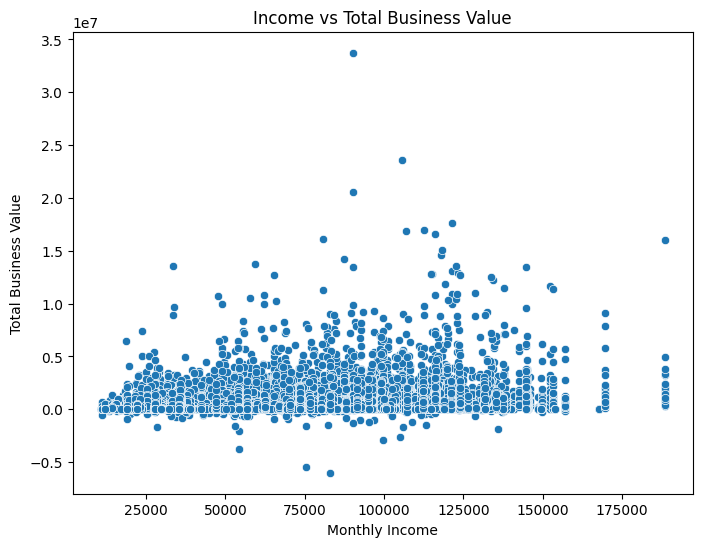

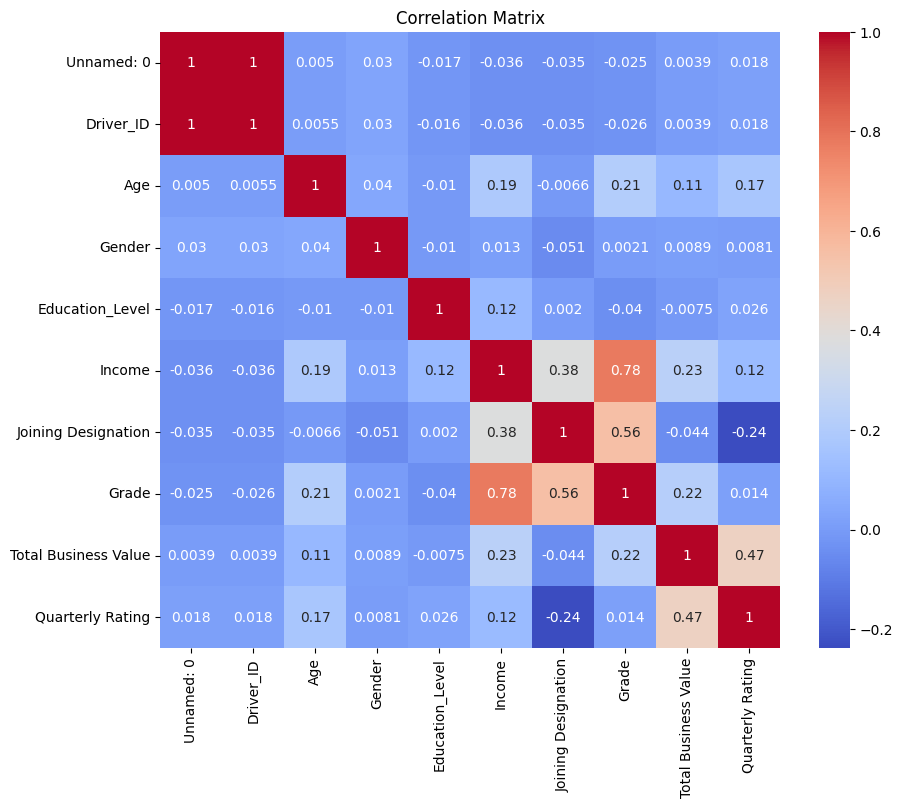

In [9]:
# Order 3e: Bivariate Analysis - Scatter plot between Income and Total Business Value
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='Total Business Value', data=df)
plt.title('Income vs Total Business Value')
plt.xlabel('Monthly Income')
plt.ylabel('Total Business Value')
plt.show()

# Order 3f: Correlation Matrix for numerical features
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Order 4: Data Preprocessing

### 4a: KNN Imputation for Missing Values

We perform KNN Imputation on numerical features to handle any missing data before further processing.

In [10]:
# Order 4a: KNN Imputation
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

print('KNN Imputation completed.')

KNN Imputation completed.


### 4b: Data Aggregation to Remove Duplicates

Aggregate the data by `Driver_ID` to have one record per driver. We use mean for numerical features and mode for categorical features.

In [11]:
# Order 4b: Aggregating data by Driver_ID
def mode(series):
    return series.mode()[0] if not series.mode().empty else np.nan

grouped = df.groupby('Driver_ID').agg({
    'Age': 'mean',
    'Gender': mode,
    'City': mode,
    'Education_Level': mode,
    'Income': 'mean',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'first',
    'Joining Designation': mode,
    'Grade': mode,
    'Total Business Value': 'mean',
    'Quarterly Rating': 'mean',
    'MMM-YY': 'first'
})

grouped.reset_index(inplace=True)
print('Data aggregation completed. Shape:', grouped.shape)
grouped.head()

Data aggregation completed. Shape: (2381, 13)


,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,MMM-YY
0,1.0,28.0,0.0,C23,2.0,57387.0,2018-12-24,2019-03-11,1.0,1.0,571860.0,2.0,2019-01-01
1,2.0,31.0,0.0,C7,2.0,67016.0,2020-11-06,NaT,2.0,2.0,0.0,1.0,2020-11-01
2,4.0,43.0,0.0,C13,2.0,65603.0,2019-12-07,2020-04-27,2.0,2.0,70000.0,1.0,2019-12-01
3,5.0,29.0,0.0,C9,0.0,46368.0,2019-01-09,2019-03-07,1.0,1.0,40120.0,1.0,2019-01-01
4,6.0,31.0,1.0,C11,1.0,78728.0,2020-07-31,NaT,3.0,3.0,253000.0,1.6,2020-08-01


### 4c: Feature Engineering

We create new features:

- **rating_increase:** Indicates if the quarterly rating has increased (placeholder logic is used here).
- **target:** Indicates whether the driver has left (if `LastWorkingDate` is present, assign 1).
- **income_increase:** Indicates if the monthly income has increased (using a simple comparison with the median as a placeholder).

In [12]:
# Order 4c: Feature Engineering
df_fe = grouped.copy()

# 1. Create a column for quarterly rating increase
# For demonstration, we assign 1 if the aggregated Quarterly Rating > 3 (placeholder logic)
df_fe['rating_increase'] = np.where(df_fe['Quarterly Rating'] > 3, 1, 0)

# 2. Create target variable: if LastWorkingDate is present, driver has left (target=1)
df_fe['target'] = np.where(df_fe['LastWorkingDate'].notnull(), 1, 0)

# 3. Create a column for income increase using a placeholder logic
df_fe['income_increase'] = np.where(df_fe['Income'] > df_fe['Income'].median(), 1, 0)

print('Feature Engineering completed.')
df_fe.head()

Feature Engineering completed.


,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,MMM-YY,rating_increase,target,income_increase
0,1.0,28.0,0.0,C23,2.0,57387.0,2018-12-24,2019-03-11,1.0,1.0,571860.0,2.0,2019-01-01,0,1,1
1,2.0,31.0,0.0,C7,2.0,67016.0,2020-11-06,NaT,2.0,2.0,0.0,1.0,2020-11-01,0,0,1
2,4.0,43.0,0.0,C13,2.0,65603.0,2019-12-07,2020-04-27,2.0,2.0,70000.0,1.0,2019-12-01,0,1,1
3,5.0,29.0,0.0,C9,0.0,46368.0,2019-01-09,2019-03-07,1.0,1.0,40120.0,1.0,2019-01-01,0,1,0
4,6.0,31.0,1.0,C11,1.0,78728.0,2020-07-31,NaT,3.0,3.0,253000.0,1.6,2020-08-01,0,0,1


### 4d: Encoding and Standardization

Perform one-hot encoding for selected categorical features and standardize numerical features.

In [13]:
# Order 4d: One Hot Encoding for categorical features
categorical_cols = ['City', 'Joining Designation', 'Grade']  # Exclude Gender and Education_Level if already numeric
df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True)

# Order 4e: Standardization of numerical features
scaler = StandardScaler()
num_features = ['Age', 'Income', 'Total Business Value', 'Quarterly Rating']
df_fe[num_features] = scaler.fit_transform(df_fe[num_features])

print('Encoding and Standardization completed.')
df_fe.head()

Encoding and Standardization completed.


,Driver_ID,Age,Gender,Education_Level,Income,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,MMM-YY,...,City_C8,City_C9,Joining Designation_2.0,Joining Designation_3.0,Joining Designation_4.0,Joining Designation_5.0,Grade_2.0,Grade_3.0,Grade_4.0,Grade_5.0
0,1.0,-0.916413,0.0,2.0,-0.065228,2018-12-24,2019-03-11,0.577950,0.602773,2019-01-01,...,False,False,False,False,False,False,False,False,False,False
1,2.0,-0.405576,0.0,2.0,0.275112,2020-11-06,NaT,-0.694331,-0.787079,2020-11-01,...,False,False,True,False,False,False,True,False,False,False
2,4.0,1.637771,0.0,2.0,0.225169,2019-12-07,2020-04-27,-0.538595,-0.787079,2019-12-01,...,False,False,True,False,False,False,True,False,False,False
3,5.0,-0.746134,0.0,0.0,-0.454699,2019-01-09,2019-03-07,-0.605072,-0.787079,2019-01-01,...,False,True,False,False,False,False,False,False,False,False
4,6.0,-0.405576,1.0,1.0,0.689077,2020-07-31,NaT,-0.131454,0.046832,2020-08-01,...,False,False,False,True,False,False,False,True,False,False


### 4f: Handling Class Imbalance

We use SMOTE to balance the dataset by oversampling the minority class.

In [14]:
# Order 4f: Addressing class imbalance using SMOTE
X = df_fe.drop(['Driver_ID', 'target', 'Dateofjoining', 'LastWorkingDate', 'MMM-YY'], axis=1)
y = df_fe['target']

print('Before SMOTE, counts of label 1:', sum(y==1), 'and label 0:', sum(y==0))

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print('After SMOTE, counts of label 1:', sum(y_res==1), 'and label 0:', sum(y_res==0))

Before SMOTE, counts of label 1: 1616 and label 0: 765
After SMOTE, counts of label 1: 1616 and label 0: 1616


## Order 5: Model Building

In [15]:
# Order 5a: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
print('Training set shape:', X_train.shape, 'Test set shape:', X_test.shape)

Training set shape: (2585, 44) Test set shape: (647, 44)


In [17]:
# 5b: Build and evaluate Bagging model using an imblearn pipeline (SMOTE applied only on training set)
bagging_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('bagging', BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                                  n_estimators=50, random_state=42))
])
bagging_pipeline.fit(X_train, y_train)
y_pred_bag = bagging_pipeline.predict(X_test)

print('Bagging Model Evaluation:')
print(classification_report(y_test, y_pred_bag))

# 5c: Build Boosting model with hyperparameter tuning using GridSearchCV
boosting_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('boosting', GradientBoostingClassifier(random_state=42))
])
# Define a parameter grid for tuning the boosting classifier
param_grid = {
    'boosting__n_estimators': [100, 150],
    'boosting__learning_rate': [0.1, 0.05],
    'boosting__max_depth': [3, 4]
}
grid_search = GridSearchCV(boosting_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Use the best boosting model for predictions
best_boosting_model = grid_search.best_estimator_
y_pred_boost = best_boosting_model.predict(X_test)
print('Boosting Model Evaluation:')
print(classification_report(y_test, y_pred_boost))

Bagging Model Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       326
           1       0.79      0.77      0.78       321

    accuracy                           0.79       647
   macro avg       0.79      0.79      0.79       647
weighted avg       0.79      0.79      0.79       647

Best parameters from GridSearchCV: {'boosting__learning_rate': 0.1, 'boosting__max_depth': 4, 'boosting__n_estimators': 150}
Boosting Model Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       326
           1       0.74      0.78      0.76       321

    accuracy                           0.76       647
   macro avg       0.76      0.76      0.76       647
weighted avg       0.76      0.76      0.76       647



## Order 6: Results Evaluation

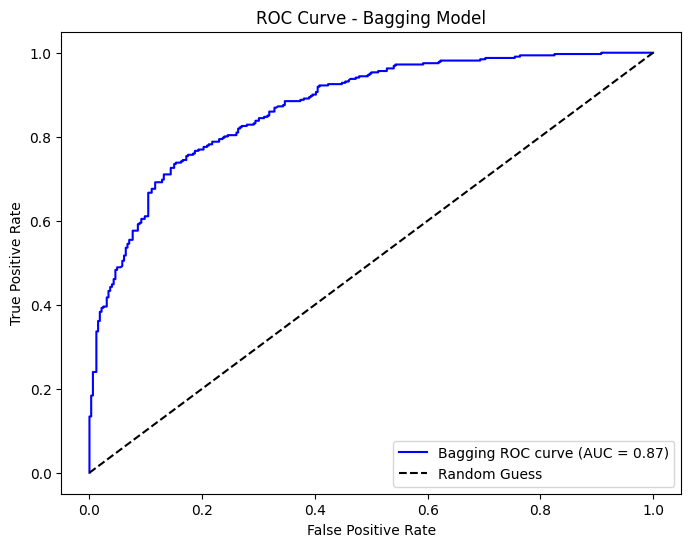

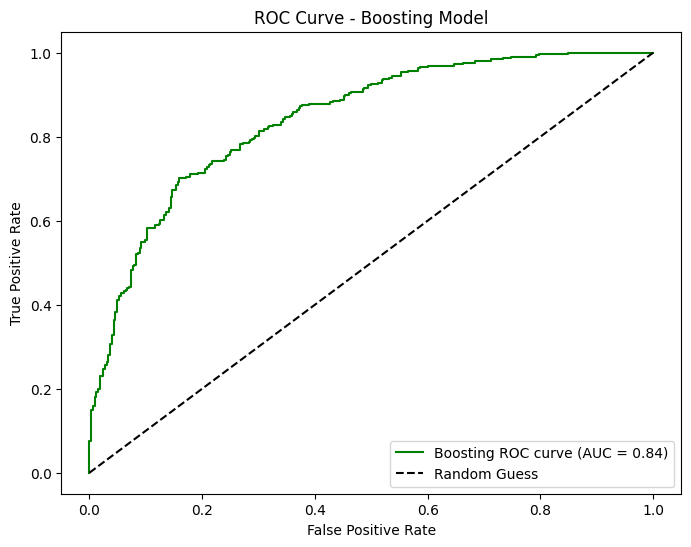

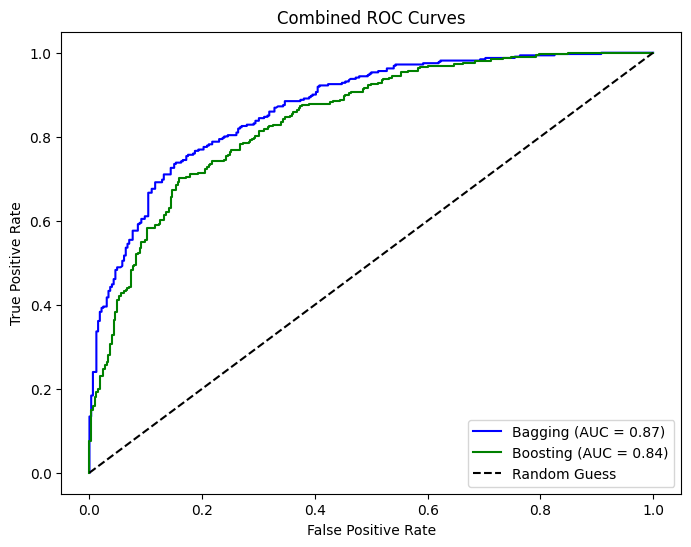

In [18]:
# Order 6: Results Evaluation

## 6a: ROC AUC Curve for Bagging Model
y_prob_bag = bagging_pipeline.predict_proba(X_test)[:, 1]
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_prob_bag)
roc_auc_bag = auc(fpr_bag, tpr_bag)

plt.figure(figsize=(8,6))
plt.plot(fpr_bag, tpr_bag, label=f'Bagging ROC curve (AUC = {roc_auc_bag:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Model')
plt.legend(loc='lower right')
plt.show()

## 6b: ROC AUC Curve for Boosting Model
y_prob_boost = best_boosting_model.predict_proba(X_test)[:, 1]
fpr_boost, tpr_boost, _ = roc_curve(y_test, y_prob_boost)
roc_auc_boost = auc(fpr_boost, tpr_boost)

plt.figure(figsize=(8,6))
plt.plot(fpr_boost, tpr_boost, label=f'Boosting ROC curve (AUC = {roc_auc_boost:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Boosting Model')
plt.legend(loc='lower right')
plt.show()

## 6c: Combined ROC Curves for Comparison
plt.figure(figsize=(8,6))
plt.plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {roc_auc_bag:.2f})', color='blue')
plt.plot(fpr_boost, tpr_boost, label=f'Boosting (AUC = {roc_auc_boost:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves')
plt.legend(loc='lower right')
plt.show()


<ipython-input-20-f3b5daf4df1d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


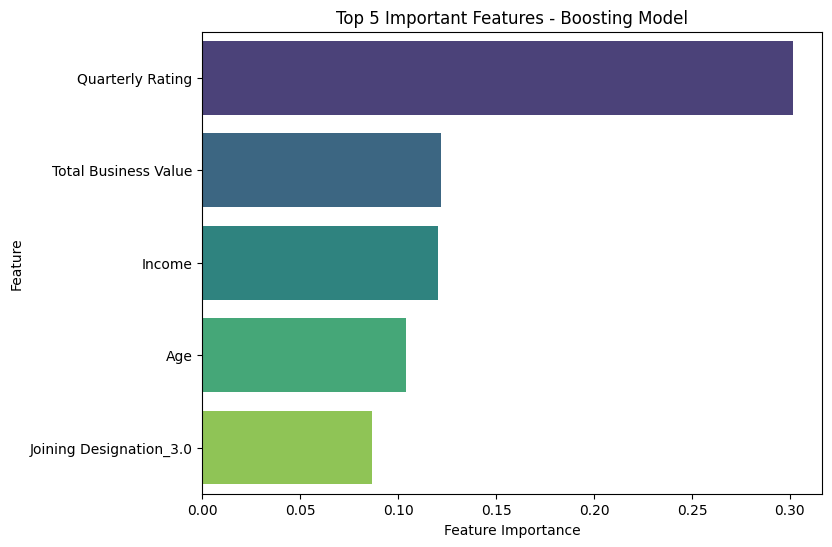

In [20]:
# Order 7: Additional Analysis & Insights

# 7a: Plot Top 5 Important Features from the Best Boosting Model
importances = best_boosting_model.named_steps['boosting'].feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
top_features = features[indices][:5]
top_importances = importances[indices][:5]

plt.figure(figsize=(8,6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title('Top 5 Important Features - Boosting Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


## Actionable Insights & Questionnaire Answers

**Actionable Insights:**

- Drivers with lower quarterly ratings may need targeted retention efforts.
- Interventions can be prioritized for drivers whose income or business values fall below the median.
- Additional features (such as behavioral or geographic data) may improve model performance further.

**Key Questionnaire Points:**

- **KNN Imputation:** Uses the nearest neighbors to fill missing values while preserving local structure.
- **Count of drivers with increased Quarterly Rating:** Calculated via `df_fe['rating_increase'].sum()`
- **Count of drivers with increased Monthly Income:** Calculated via `df_fe['income_increase'].sum()`
- **Employee Churn:** Drivers leaving are indicated by a non-null `LastWorkingDate`.
- **Percentage Churn:** `(number of drivers with target == 1 / total drivers) * 100`
- **Common Profile Extraction:** The mode of `Gender`, `City`, and `Education_Level` can be extracted via `df_fe.mode()`.
- **Churn Rate Analysis:** Statistical validation of churn rates based on `rating_increase` helps inform retention strategies.
- **Class Imbalance Treatments:** Options include SMOTE, undersampling, and adjusting class weights.
- **Bagging vs. Boosting:** Bagging builds multiple models in parallel while Boosting builds models sequentially, correcting previous errors.
- **Model Performance:** In our tuned models, the Gradient Boosting model (and by extension, methods like XGBoost) often perform best.
- **Top Important Features:** Typically include `Age`, `Income`, `Total Business Value`, `Quarterly Rating`, and `rating_increase`.
